# Data Science coding challenge
Download a mysql database dump from the following link:

https://storage.googleapis.com/coding-challenge/data_scientist.tar.gz

This is a synthetic version of a part of our database including tables about users and rooms and interactions. Tables are the following:
* rooms : Rooms in our platform and some of their characteristics
* room_users : Table that links rooms with the users that uploaded those rooms. We call these users listers. Users that aren’t here did not upload rooms, and we call them seekers.
* room_amenities : Some characteristics of the rooms, whether they have tv, washing machine, etc.
* room_prices : information about rooms and their prices.
* requests : We are a marketplace and users can request rooms. This table collect this information, i.e. what user ( user_id ) requested what room ( room_id ). A request can be in a status of accepted (the lister accepted the request and ended up chatting with the user), with value 2, or rejected (the lister did not accept the request) with value 3.


## QUESTIONS
### 1. Using the database dump provided, try to come up with a model to predict room prices. Evaluate its performance. Which variables do you think are most relevant? There’s no right or wrong answer, just be creative :)

* In section 1. I focused on merging of the datasets, converting currencies, removing empty cells, assigning a neighborhood to each room depending on the location (I used neighborhood polygons form airbnb)
* In section 2. I adjusted the dataset so it can be ussed by ML algorithms and applied default versions of XGBoost(regression) and SVR. XGBoost gained on popularity thanks to its good performance on Kaggle competitions and I noticed that some people had good results with SVR. I also tried to change the problem from regression to classification and divided te prices to 10 groups based on percentiles. Due to time limit I didn't perform parameter adjustment. Possible reasons for bad ML results : (i) more features. (ii) more data points, (iii) algorithm parameter adjustment, (iv) feature selection/filtering (e.g. some prices are too low - 20EUR etc., which does not sound right...)
* In section 3. I summarized next steps (except the ones I already mentioned)


### 2. If you had to produce an explanation to the final user, or a stakeholder of Badi of what determines the price of a specific room, how would you do it?
* Show series of graphs or table with price median for each amenity true/false, i.e. what is the price difference when amenity is present or not
* explain the feature importance output from XGBOOST algorithm
* calculate feature selection algorithm score for each feature, explain the score and show bar chart for all features (preferably feature selection score with lower/upper boundary )


### 3. How would you deploy such algorithm in production? what steps in terms of product would you take?
* I would adjust the model to take the "room feature vector" as an input and make a prediction from a model impelemented in AWS/Azure. The model would be trained on local server/computer if possible. I would periodically retrain the model when I have more data points, evaluate it, and adjust model paramters to give accurate predictions(or come up with new model/models/ensemble/...). There are many guides/blogs how to do it in AWS/AZURE, eg. 
 * https://towardsdatascience.com/simple-way-to-deploy-machine-learning-models-to-cloud-fd58b771fdcf
 * https://www.coursera.org/learn/deploying-machine-learning-models
 * https://towardsdatascience.com/deploy-model-b15d83b6b9fa
 etc.

# 0. Libraries

In [22]:
#!/home/big-dama/anaconda3/bin/python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, urllib.request
# https://xgboost.readthedocs.io/en/latest/
import xgboost
from sklearn.svm import SVR
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from skfeature.function.similarity_based import lap_score
#import geopandas

%matplotlib inline

# 1. PREPROCESSING

## Load datasets

In [3]:
# data from BADI
requests_loc = 'datasets/requests.csv'
room_amenities_loc = 'datasets/room_amenities.csv'
room_prices_loc = 'datasets/room_prices.csv'
room_users_loc = 'datasets/room_users.csv'
rooms_loc = 'datasets/rooms.csv'
rooms_add_loc = 'datasets/rooms_add.csv'
rooms_geo_loc = 'datasets/rooms.geojson'

# downloaded neighborhoods from http://insideairbnb.com/get-the-data.html
neighborhoods_barcelona_loc = 'datasets/neighbourhoods_barcelona.geojson'
neighborhoods_madrid_loc = 'datasets/neighbourhoods_madrid.geojson'
neighborhoods_london_loc = 'datasets/neighbourhoods_london.geojson'

requests_pd = pd.read_csv(requests_loc, index_col=False)
room_amenities_pd = pd.read_csv(room_amenities_loc, index_col=False)
room_prices_pd = pd.read_csv(room_prices_loc, index_col=False)
room_users_pd = pd.read_csv(room_users_loc, index_col=False)
rooms_pd = pd.read_csv(rooms_loc, index_col=False)
rooms_add_pd = pd.read_pickle(rooms_add_loc)

rooms_gpd = gpd.read_file(rooms_geo_loc)

neighborhoods_barcelona_gpd = gpd.read_file(neighborhoods_barcelona_loc)
neighborhoods_madrid_gpd = gpd.read_file(neighborhoods_madrid_loc)
neighborhoods_london_gpd = gpd.read_file(neighborhoods_london_loc)

'\nrooms_gpd = gpd.read_file(rooms_geo_loc)\n\nneighborhoods_barcelona_gpd = gpd.read_file(neighborhoods_barcelona_loc)\nneighborhoods_madrid_gpd = gpd.read_file(neighborhoods_madrid_loc)\nneighborhoods_london_gpd = gpd.read_file(neighborhoods_london_loc)\n'

## 1.1 Extract additional features from requests_pd and room_users_pd

In [4]:
room_users_pd['lister'] = 1
room_users_pd.drop(columns=['room_id','created_at'],inplace=True)

# merge requests_pd and room_users_pd to extract demand for rooms from seekers and listers
requests_pd = pd.merge(requests_pd,room_users_pd,on='user_id',how = 'left')
requests_pd['seeker'] = ''
requests_pd['seeker'][requests_pd['lister'] != 1] = 1
requests_pd.replace(['',np.nan],0,inplace=True)

requests_grp_pd = requests_pd.groupby(['room_id'],as_index=False).agg({'lister':'sum','seeker':'sum'})
requests_grp_pd['demand'] = requests_grp_pd['lister'] + requests_grp_pd['seeker']
requests_grp_pd.rename(columns={'lister': 'demand_lister', 'seeker': 'demand_seeker'},inplace=True)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 1.2 Check the "main dataset" room_prices.csv 

In [5]:
# check for duplicate room_ids in room_prices
room_prices_pd[room_prices_pd.duplicated(subset=['room_id'],keep=False)]

,room_id,price,currency,bills_included,created_at
86424,f3c58cdacf15,700.0,NaN,NaN,2018-04-09 10:41:21+00:00
118849,f3c58cdacf15,500.0,GBP,NaN,2018-03-13 15:28:02+00:00


In [6]:
# check if there is such room in rooms.csv
rooms_pd[rooms_pd['id']=='f3c58cdacf15']

,id,bed_type,description,country_id,latitude,longitude,min_days,male_tenants,female_tenants,created_at


In [7]:
# manually fill newer value and drop the older one
room_prices_pd['currency'].iloc[86424] = 'GBP'
room_prices_pd.drop(index=118849,inplace=True)

/home/big-dama/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## 1.3 Check the location of the rooms
(result - it seems rooms are only in Madrid, Barcelona, London)

In [55]:
# apparently rooms.csv includes only minor number of the rooms from room_prices.csv ()
print('Number of rooms in rooms_prices.csv :'+str(len(room_prices_pd))+'\nNumber of rooms in rooms.csv : '+str(len(rooms_pd)))

Number of rooms in rooms_prices.csv :291330
Number of rooms in rooms.csv : 78692


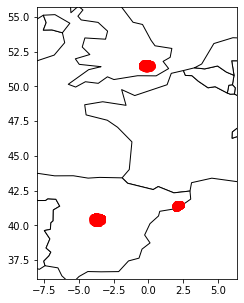

In [22]:
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
gdf = geopandas.GeoDataFrame(rooms_pd, geometry=geopandas.points_from_xy(rooms_pd.longitude, rooms_pd.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world[world.continent == 'Europe'].plot(color='white', edgecolor='black',ax=ax)          
gdf.plot(ax=ax,color='red',alpha = 0.5)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-4, maxx+4)
ax.set_ylim(miny-4, maxy+4)
#ax.set_axis_off()
plt.show()

### 1.3.1 Assign City to each room

In [126]:
# create a new columns with city name
rooms_pd['city_id'] = ''
rooms_pd['city_id'][(rooms_pd['longitude']>0) & (rooms_pd['country_id']=='Spain')] = 0
rooms_pd['city_id'][(rooms_pd['longitude']<0) & (rooms_pd['country_id']=='Spain')] = 1
rooms_pd['city_id'][rooms_pd['country_id']=='United Kingdom'] = 2
# as the final dataset would have 2 'created_at' columns which could be an issue if I want ot use the data later..
# rename id to room_id so I don't have to drop column later after final merge
rooms_pd.rename(columns={'created_at': 'created_at(rooms_csv)','id': 'room_id'},inplace=True)

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

### 1.3.2 Assign Neighborhood and Neighborhood group to each room

In [ ]:
rooms_gpd = geopandas.GeoDataFrame(rooms_pd, geometry=geopandas.points_from_xy(rooms_pd.longitude, rooms_pd.latitude))
rooms_gpd['neighbourhood'] = ''
rooms_gpd['neighbourhood_group'] = ''

In [ ]:
for row in rooms_gpd.index.values:
    if rooms_gpd['city_id'][row] == 'Barcelona':
        for row_neigh in neighborhoods_barcelona_gpd.index.values:
            if rooms_gpd['geometry'][row].within(neighborhoods_barcelona_gpd['geometry'][row_neigh]):
                #print('ano_bcn')
                rooms_gpd['neighbourhood'].iloc[row] = neighborhoods_barcelona_gpd['neighbourhood'].iloc[row_neigh]
                rooms_gpd['neighbourhood_group'].iloc[row] = neighborhoods_barcelona_gpd['neighbourhood_group'].iloc[row_neigh]
    if rooms_gpd['city_id'][row] == 'Madrid':
        for row_neigh in neighborhoods_madrid_gpd.index.values:
            if rooms_gpd['geometry'][row].within(neighborhoods_madrid_gpd['geometry'][row_neigh]):
                #print('ano_mdr')
                rooms_gpd['neighbourhood'].iloc[row] = neighborhoods_madrid_gpd['neighbourhood'][row_neigh]
                rooms_gpd['neighbourhood_group'].iloc[row] = neighborhoods_madrid_gpd['neighbourhood_group'].iloc[row_neigh]                
    if rooms_gpd['city_id'][row] == 'London':
        for row_neigh in neighborhoods_london_gpd.index.values:
            if rooms_gpd['geometry'][row].within(neighborhoods_london_gpd['geometry'][row_neigh]):
                #print('ano_ldn')
                rooms_gpd['neighbourhood'].iloc[row] = neighborhoods_london_gpd['neighbourhood'].iloc[row_neigh]
                rooms_gpd['neighbourhood_group'].iloc[row] = neighborhoods_london_gpd['neighbourhood_group'].iloc[row_neigh]

rooms_gpd.to_file("datasets/rooms.geojson", driver="GeoJSON")
pd.DataFrame(rooms_gpd).to_pickle('datasets/rooms_add.csv')

## 1.4 Merge the datasets

In [8]:
# if I understand it correctly there are 22 types of room amenities, each room can have several types
# so I transformed them to binary vector of length 22 so I can use them in model

# room_amenities_pd has many suplicate rows, remove them
room_amenities_pd.drop_duplicates(inplace=True)
# transform room_amenities_pd to dataframe that will have 22 columns representing all amenity types
room_amenities_bin_pd = pd.concat([room_amenities_pd.drop('amenity_type', 1), pd.get_dummies(room_amenities_pd.amenity_type).mul(1)], axis=1)
room_amenities_bin_pd = room_amenities_bin_pd.groupby('room_id',as_index=False).sum()

# merge prices with with amenities
dataset = pd.merge(room_prices_pd,room_amenities_bin_pd,how = 'inner')
# as the final dataset would have 2 'created_at' columns which could be an issue if I want ot use the data later..
dataset.rename(columns={'created_at': 'created_at(room_price_csv)'},inplace=True)

# merge with rooms_add_pd
dataset = pd.merge(dataset,rooms_add_pd,on='room_id',how = 'left')
dataset = pd.merge(dataset,requests_grp_pd,on='room_id',how = 'left')

# I assume that rooms that were not in requests.csv are rooms that were not yet requested so I will put 0 into the cells
dataset[['demand','demand_lister','demand_seeker']].replace([np.nan],0,inplace=True)

# remove price 0 - it doesn't sound right :) 
print('Number of rows with 0 price : ' + str(len(dataset[dataset['price']==0])))
dataset.drop(dataset[dataset['price'] == 0].index, inplace=True)

# remove rows without currency
print('Number of rows without currency : ' + str(len(dataset[dataset['currency'].isna()])))
dataset.drop(dataset[dataset['currency'].isna()].index, inplace=True)

print('Number of rooms in rooms_prices.csv :'+str(len(room_prices_pd))+
      '\nNumber of rooms in rooms.csv : '+str(len(rooms_pd))+
      '\nNumber of rooms in room_amenities.csv : '+str(len(room_amenities_bin_pd))+
      '\nNumber of rows in dataset : '+str(len(dataset)))

Number of rows with 0 price : 1528
Number of rows without currency : 322
Number of rooms in rooms_prices.csv :291330
Number of rooms in rooms.csv : 78692
Number of rooms in room_amenities.csv : 234044
Number of rows in dataset : 206989


/home/big-dama/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


### 1.4.1 Find out currency exchange rate to EUR from all currencies

In [ ]:
# inspired by https://www.101computing.net/currency-converter/
# free API limit is 100 requests per hour

currencyFrom_list = dataset['currency'].unique()

currencyTo = 'EUR'
list_of_rates = list()
for currencyFrom in currencyFrom_list[67:]:
    #url = 'https://free.currconv.com/api/v7/convert?q='+currencyFrom + '_' + currencyTo +'&compact=ultra&apiKey=4c1347ec42d660af57dc'
    url = 'https://free.currconv.com/api/v7/convert?q='+currencyFrom + '_' + currencyTo +'&compact=ultra&apiKey=b8e462166e8cbaf7f84d'
    response = urllib.request.urlopen(url)
    result = json.loads(response.read())
    list_of_rates.append(result[currencyFrom + '_' + currencyTo])

In [9]:
# I had to run the query 2x because I run out of free requests in 1 hour as there are 110 currencies and only 100 reuests allowed in 1 hour
currencyFrom_list = dataset['currency'].unique()
list_of_rates = [1, 1.198291, 2.14E-05, 0.010589, 0.007525, 0.055788, 0.68302, 0.012722, 0.01994, 0.316607, 0.899281, 0.047299, 0.001528, 6.44E-05, 0.001176, 0.154829, 0.239775, 0.00014, 0.218888, 0.0383, 0.000756, 9.45E-05, 0.005804, 0.244833, 2.963518, 0.009061, 0.007943, 0.258186, 0.008164, 0.001746, 0.016916, 0.033935, 0.003033, 0.095684, 0.618399, 0.000766, 0.209276, 0.015046, 2.384766, 0.000266, 0.002481, 0.090041, 0.000596, 0.899482, 0.527756, 0.234267, 0.061932, 1.267478, 0.217506, 0.267084, 0.128968, 0.24697, 0.093651, 0.913782, 0.31498, 0.13008, 0.899482, 0.029763, 0.000221, 0.117202, 0.061929, 0.008511, 0.01431, 0.001883, 0.023687, 0.008225, 0.593502, 0.664404, 0.134414, 0.004967, 0.062006, 0.099569, 0.001532, 3.88E-05, 0.154382, 0.036342, 0.133807, 0.016346, 0.001582, 0.511195, 0.039256, 0.017767, 0.000391, 0.051996, 0.008842, 0.000245, 0.026566, 0.024671, 0.003593, 0.028413, 0.115315, 0.332753, 0.007298, 0.002338, 0.000595, 4.59E-05, 0.014139, 0.00155, 0.006398, 0.011419, 0.513982, 0.445515, 0.029743, 0.058167, 2.3358, 0.64004, 0.00194, 0.00033, 0.012875, 0.000971]
cur_exchg_rate_pd = pd.DataFrame({'currency' : currencyFrom_list, 'exchange_rate' : list_of_rates})

### 1.4.2 Calculate room prices in EUR

In [11]:
dataset = pd.merge(dataset,cur_exchg_rate_pd,on='currency',how = 'left')
dataset['price_EUR'] = dataset['price'] * dataset['exchange_rate']

# partition the prices to 10 groups based on percentiles for a scenario in which I will treat the dataset as classificaiton issue - not regression
dataset['price_class'] = np.floor(dataset['price_EUR'].rank(pct=True)*10).astype(int)
dataset.to_pickle('datasets/dataset.csv')

## 1.5 Feature analysis

In [22]:
dataset = pd.read_pickle('datasets/dataset.csv')
prices = ['price_EUR','price_class']
amenity_columns = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
other_possibly_usefull_columns = ['city_id','country_id','bills_included','min_days', 
                                  'male_tenants','female_tenants',
                                  'demand_lister', 'demand_seeker', 'demand',
                                  'neighbourhood', 'neighbourhood_group']
ml_dataset = dataset[amenity_columns+other_possibly_usefull_columns+prices]

### 1.5.1 Room prices distribution/outliers

Text(0.5, 1.05, 'Range from min to\nmax including outliers')

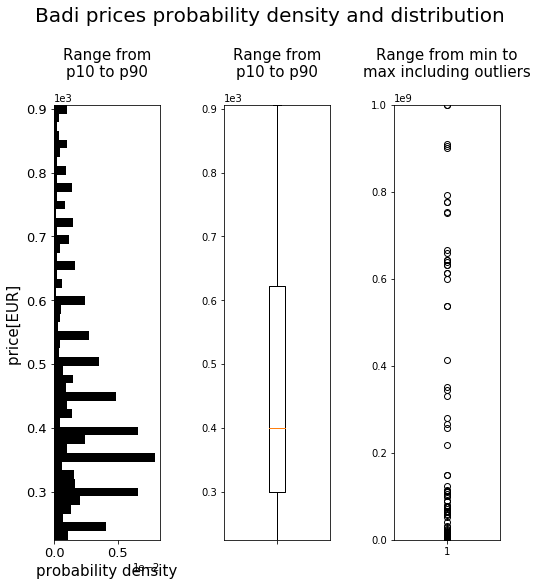

In [28]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.6)

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey = ax1)
ax3 = fig.add_subplot(1, 3, 3)

fig.suptitle('Badi prices probability density and distribution',y=1.05, size=20)

lower_percentile = 10
upper_percentile = 90

lower_boundary = np.percentile(dataset['price_EUR'],10)
upper_boundary = np.percentile(dataset['price_EUR'],90)

ax1.hist(ml_dataset['price_EUR'], color='black',bins = 50, range=[lower_boundary,upper_boundary], density=True,orientation="horizontal")
ax1.set_xlabel('probability density', size=16)
ax1.set_ylabel('price[EUR] ',size=16)
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax1.tick_params(labelsize=13)
ax1.set_ylim([lower_boundary,upper_boundary])
ax1.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
ax1.set_title('Range from\np'+str(lower_percentile)+' to p'+str(upper_percentile),y=1.05,size=15)

ax2.boxplot(ml_dataset['price_EUR'], whis=[lower_percentile,upper_percentile], showfliers=False,)
ax2.set_xticklabels([''])
ax2.set_ylim([lower_boundary,upper_boundary])
ax2.set_title('Range from\np'+str(lower_percentile)+' to p'+str(upper_percentile),y=1.05,size=15)

ax3.boxplot(ml_dataset['price_EUR'], showfliers=True,)
ax3.set_ylim(dataset['price_EUR'].min(),dataset['price_EUR'].max())
ax3.set_title('Range from min to\nmax including outliers',y=1.05,size=15)

### 1.5.2 Correlation of features - single city, otherwise it's not readable

In [39]:
city = 'Barcelona'
ml_dataset_transformed = pd.get_dummies(ml_dataset[ml_dataset['city_id']=='Barcelona'].drop(columns=['country_id']))
ml_dataset_transformed = ml_dataset_transformed.dropna()

for col in ml_dataset_transformed.columns.tolist():
    if col != 'price_EUR':
        ml_dataset_transformed = ml_dataset_transformed.astype({col: 'int32'})
    ml_dataset_transformed = ml_dataset_transformed[ml_dataset_transformed[col] >= 0]
    
dataset_corr = ml_dataset_transformed[ml_dataset_transformed.columns[:-2]].corr()
correlation_threshold = 0
upper = dataset_corr.where(np.triu(np.ones(dataset_corr.shape), k = 1).astype(np.bool))
# Select the features with correlations above the threshold
# Need to use the absolute value
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

In [42]:
# Dataframe to hold correlated pairs
dataset_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

# Iterate through the columns to drop to record pairs of correlated features
for column in to_drop:

    # Find the correlated features
    corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

    # Find the correlated values
    corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(corr_features))]    

    # Record the information (need a temp df for now)
    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                     'corr_feature': corr_features,
                                     'corr_value': corr_values})
    dataset_collinear = dataset_collinear.append(temp_df, ignore_index = True)
    
dataset_corr_filtered = dataset_corr.loc[list(set(dataset_collinear['corr_feature'])), list(set(dataset_collinear['drop_feature']))]    

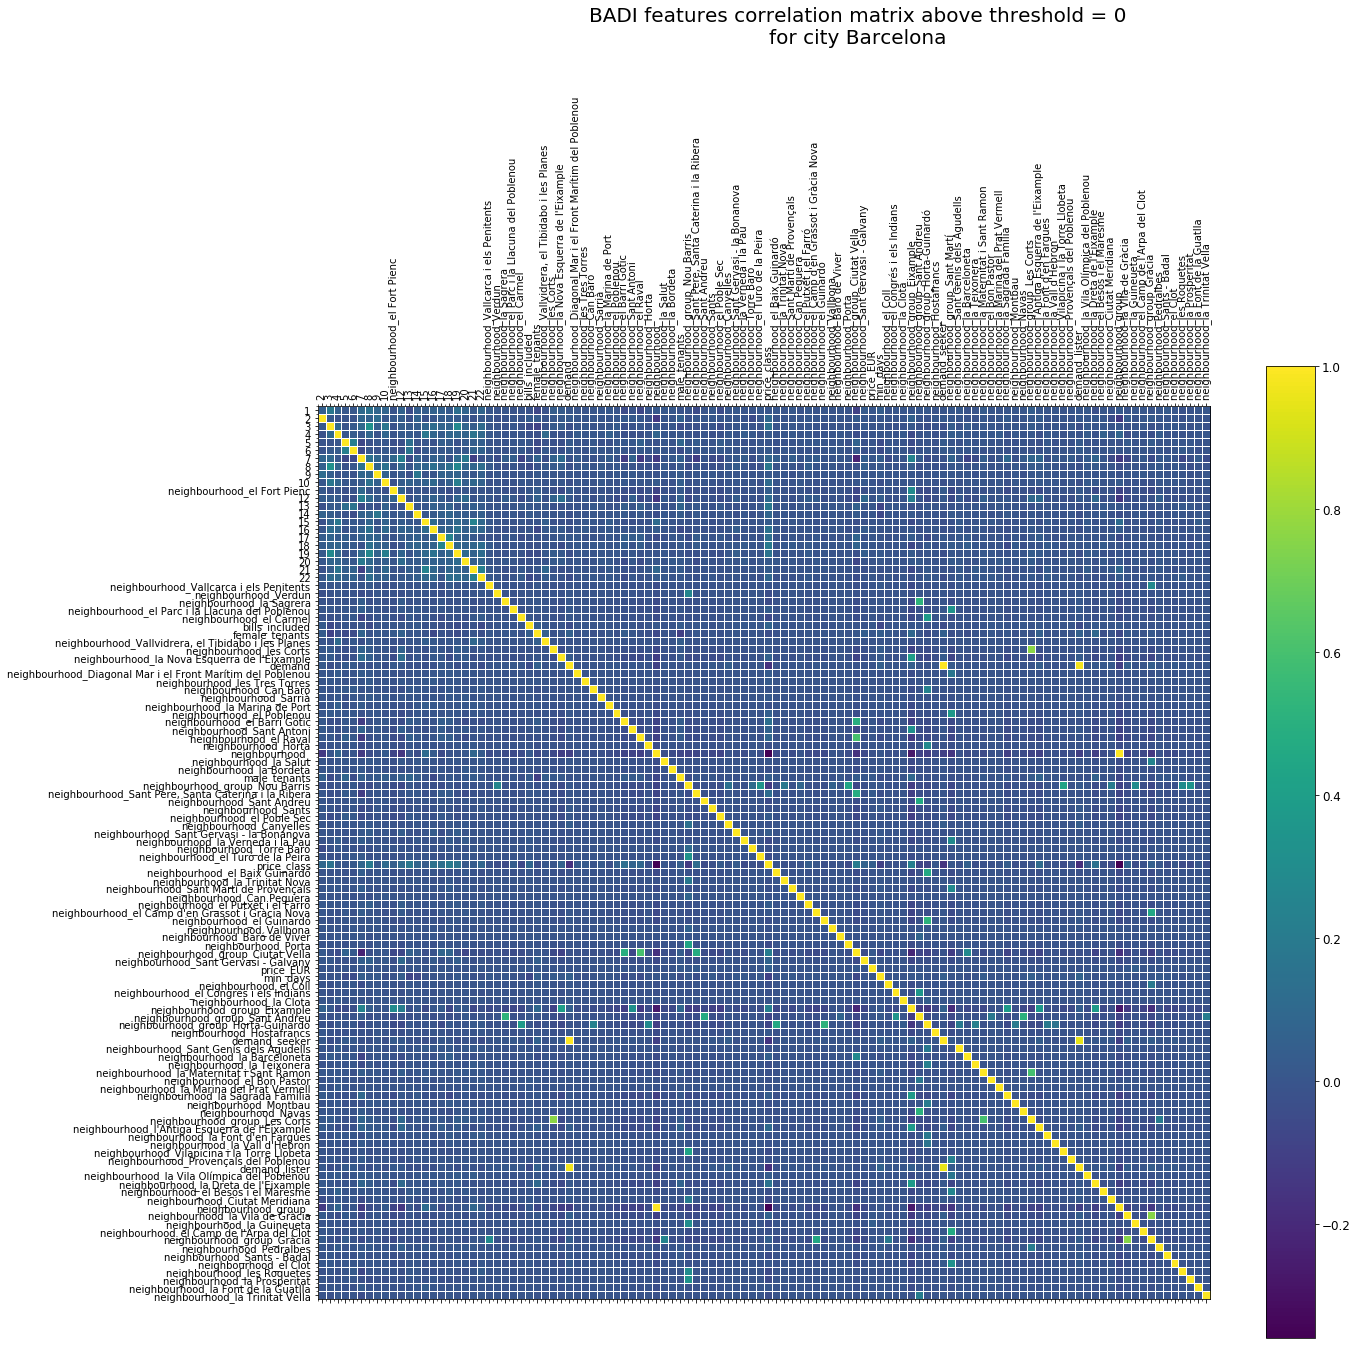

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.suptitle('BADI features correlation matrix above threshold = ' + str(correlation_threshold) + 
             '\nfor city ' + city, y=1.05, size=20)

heatmap = ax.matshow(dataset_corr_filtered)
ax.set_xticks(range(dataset_corr_filtered.shape[1]))
ax.set_xticklabels(dataset_corr_filtered.columns.values, fontsize=10, rotation=90)
ax.set_yticks(range(dataset_corr_filtered.shape[0]))
ax.set_yticklabels(dataset_corr_filtered.index.values, fontsize=10)

ax.set_xticks(np.arange(-.5, dataset_corr_filtered.shape[1]-1, 1), minor=True);
ax.set_yticks(np.arange(-.5, dataset_corr_filtered.shape[0]-1, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
cb = fig.colorbar(heatmap)
cb.ax.tick_params(labelsize=12)
plt.subplots_adjust(top=0.80)

# 2. Machine Learning

## Load datasets and feature lists

In [2]:
# read the dataset that we will use
dataset = pd.read_pickle('datasets/dataset.csv')

# labels
prices = ['price_EUR','price_class']

# data
# amenity type 11 is missing
amenity_columns = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
other_possibly_usefull_columns = ['city_id','country_id','bills_included','min_days', 
                                  'male_tenants','female_tenants',
                                  'demand_lister', 'demand_seeker', 'demand',
                                  'neighbourhood', 'neighbourhood_group']

ml_dataset_amenities = dataset[amenity_columns+prices]
ml_dataset = dataset[amenity_columns+other_possibly_usefull_columns+prices]

## 2.2 Algorithms evaluation

### 2.2.1 Barcelona

#### 2.2.1.1 Dataset filtering and adjusting for ML models

In [8]:
# filter NA and negative values from full dataset + adjust dtypes (ml_dataset_amenities is already "clean")
city = 'Barcelona'
ml_dataset_transformed_temp = pd.get_dummies(ml_dataset[ml_dataset['city_id']=='Barcelona'].drop(columns=['country_id']))
ml_dataset_transformed_temp = ml_dataset_transformed_temp.dropna()
ml_dataset_transformed_temp = ml_dataset_transformed_temp.reset_index(drop=True)

# there was a negative value in at least 1 row
for col in ml_dataset_transformed_temp.columns.tolist():
    if col != 'price_EUR':
        ml_dataset_transformed_temp = ml_dataset_transformed_temp.astype({col: 'int32'})
    ml_dataset_transformed_temp = ml_dataset_transformed_temp[ml_dataset_transformed_temp[col] >= 0]

#### 2.2.1.2 Dataset scaling

In [11]:
scaler = StandardScaler()
ml_dataset_transformed = pd.DataFrame(scaler.fit_transform(ml_dataset_transformed_temp[ml_dataset_transformed_temp.columns.difference(['price_EUR','price_class'])]), columns=list(ml_dataset_transformed_temp.columns.difference(['price_EUR','price_class'])))
ml_dataset_transformed['price_EUR'] = ml_dataset_transformed_temp['price_EUR'].copy()
# the class was previously computed for all rooms, I need to recalculate it to reflect only filtered dataset
ml_dataset_transformed['price_class'] = np.floor(ml_dataset_transformed['price_EUR'].rank(pct=True)*10).astype(int)

#### 2.2.1.3 Dataset separation to train/test

In [13]:
ml_dataset_transformed_price_train, ml_dataset_transformed_price_test, labels_price_train, labels_price_test = train_test_split(ml_dataset_transformed[ml_dataset_transformed.columns.difference(['price_EUR','price_class'])], ml_dataset_transformed['price_EUR'], test_size=0.1)
ml_dataset_transformed_priceCL_train, ml_dataset_transformed_priceCL_test, labels_priceCL_train, labels_priceCL_test = train_test_split(ml_dataset_transformed[ml_dataset_transformed.columns.difference(['price_EUR','price_class'])], ml_dataset_transformed['price_class'], test_size=0.1)

#### 2.2.1.4. SVM Regression

In [23]:
# SVR
SVM_reg = svm.SVR(kernel='rbf')
SVMscores = cross_val_score(SVM_reg, ml_dataset_transformed[ml_dataset_transformed.columns.difference(['price_EUR','price_class'])], ml_dataset_transformed['price_EUR'], scoring='neg_mean_squared_error', cv=10)
SVM_reg.fit(ml_dataset_transformed_price_train, labels_price_train)
#SVM_predicted = SVM_clf.predict(ml_dataset_transformed_price_test)
print('SVM 10CV mean MSE : ' + str(SVMscores.mean()))

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/big-dama/anaconda3/lib/python3.7/site-packa

SVM 10CV mean MSE : -18208031.682454735


#### 2.2.1.5. XGBOOST Regression

In [14]:
# XGBOOST regression
XGBOOST_reg = xgboost.XGBRegressor()
XGBOOSTscores = cross_val_score(XGBOOST_reg, ml_dataset_transformed[ml_dataset_transformed.columns.difference(['price_EUR','price_class'])], ml_dataset_transformed['price_EUR'], scoring='neg_mean_squared_error', cv=10)
XGBOOST_reg.fit(ml_dataset_transformed_price_train, labels_price_train)
#XGBOOST_reg_predicted = XGBOOST_reg.predict(ml_dataset_transformed_price_test)
print('XGBOOST_REG 10CV mean MSE : ' + str(XGBOOSTscores.mean()))

/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/big-dama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST_REG 10CV mean MSE : -25043342.72023646


In [15]:
XGBOOSTscores

array([-4.36338851e+05, -3.19769244e+05, -5.53137860e+07, -7.97784135e+07,
       -7.38638341e+05, -1.07381037e+08, -4.25747049e+06, -5.82576338e+05,
       -9.28094419e+05, -6.97303420e+05])

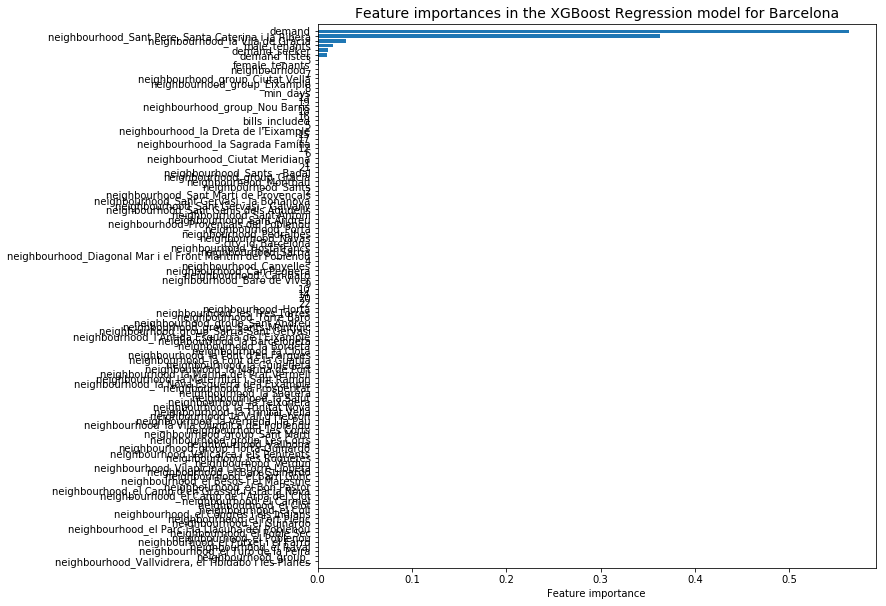

In [16]:
XGBOOST_reg_feature_weights = pd.DataFrame(XGBOOST_reg.feature_importances_, columns=['weight'], index=ml_dataset_transformed_price_train.columns)
XGBOOST_reg_feature_weights.sort_values('weight', inplace=True)

plt.figure(figsize=(10,10))
plt.barh([str(i) for i in XGBOOST_reg_feature_weights.index.values], XGBOOST_reg_feature_weights.weight, align='center') 
plt.title('Feature importances in the XGBoost Regression model for ' + city, fontsize=14)
plt.xlabel('Feature importance')
plt.margins(y=0.01)
plt.show()

#### 2.2.1.6 XGBOOST Classification

In [19]:
# XGBOOST classification
XGBOOST_clf = xgboost.XGBClassifier()
XGBOOSTscores = cross_val_score(XGBOOST_clf, ml_dataset_transformed[ml_dataset_transformed.columns.difference(['price_EUR','price_class'])], ml_dataset_transformed['price_class'], cv=10, scoring='f1_weighted')
XGBOOST_clf.fit(ml_dataset_transformed_priceCL_train, labels_priceCL_train)
XGBOOST_predicted = XGBOOST_clf.predict(ml_dataset_transformed_priceCL_test)
print('XGBOOST 10CV f1_weighted scores : ' + str(XGBOOSTscores))
print('XGBOOST classification report :\n' + str(classification_report(labels_priceCL_test, XGBOOST_predicted)))
print('XGBOOST confusion matrix :\n' + str(confusion_matrix(labels_priceCL_test, XGBOOST_predicted)))

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


XGBOOST 10CV f1_weighted scores : [0.21235471 0.22145132 0.21689349 0.18709734 0.20508251 0.19684988
 0.20690774 0.20952655 0.20322095 0.20786011]
XGBOOST classification report :
              precision    recall  f1-score   support

           0       0.36      0.65      0.47       393
           1       0.17      0.01      0.02       191
           2       0.16      0.19      0.18       317
           3       0.21      0.13      0.16       337
           4       0.16      0.07      0.10       348
           5       0.00      0.00      0.00       196
           6       0.17      0.14      0.15       368
           7       0.20      0.42      0.27       365
           8       0.30      0.09      0.13       247
           9       0.39      0.62      0.48       307

    accuracy                           0.26      3069
   macro avg       0.21      0.23      0.20      3069
weighted avg       0.22      0.26      0.22      3069

XGBOOST confusion matrix :
[[254   4  61  13   6   0  14  29  

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


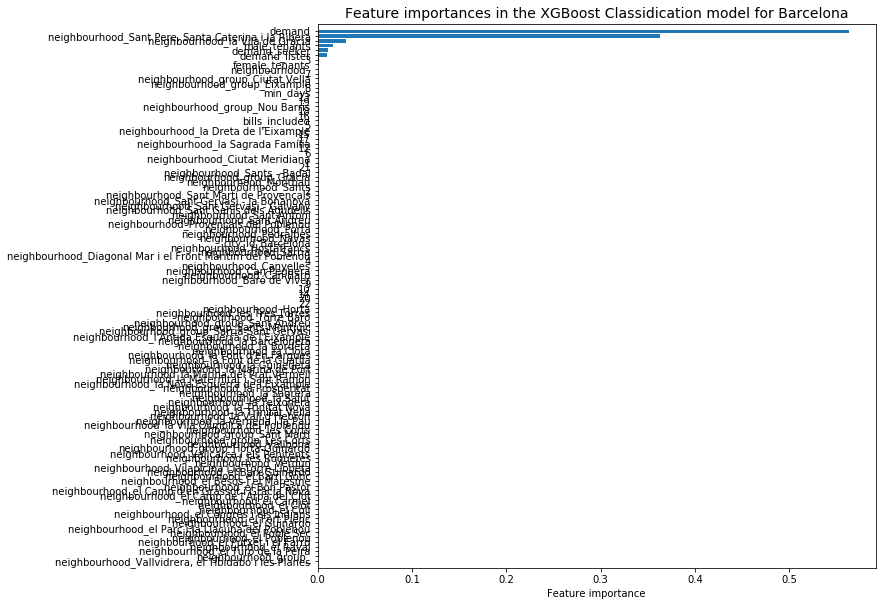

In [20]:
XGBOOST_clf_feature_weights = pd.DataFrame(XGBOOST_reg.feature_importances_, columns=['weight'], index=ml_dataset_transformed_price_train.columns)
XGBOOST_clf_feature_weights.sort_values('weight', inplace=True)

plt.figure(figsize=(10,10))
plt.barh([str(i) for i in XGBOOST_reg_feature_weights.index.values], XGBOOST_reg_feature_weights.weight, align='center') 
plt.title('Feature importances in the XGBoost Classidication model for ' + city, fontsize=14)
plt.xlabel('Feature importance')
plt.margins(y=0.01)
plt.show()

# 3. UNFINISHED

## 3.1 Feature Selection Algorithms

http://featureselection.asu.edu/

### 3.1.1 LAP score

In [ ]:
from skfeature.function.similarity_based import lap_score

dataset_lap_score = lap_score.lap_score(dataset.values)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
first = 0
last = len(dataset.columns)-1
ax.bar(np.arange(dataset.shape[1])[first:last],np.sort(dataset_lap_score)[first:last], color ='black', width=0.8)
ax.tick_params(labelsize=10)
ax.set_ylim([0,1])
ax.set_xlim([-0.5,last-first-0.5])
ax.set_xticks(np.arange(dataset.shape[1])[first:last])
labels = ax.set_xticklabels(dataset.columns.values[np.argsort(dataset_lap_score)][first:last], rotation=90)

### 3.1.X OTHER scores

similarity based:
* fisher_score - R.O. Duda, P.E. Hart, and D.G. Stork, Pattern Classification
* reliefF - Theoretical and Empirical Analysis of ReliefF and RReliefF
* trace_ratio - Trace Ratio Criterion for Feature Selection

statistical based:
* CFS - Feature selection for machine learning: Comparing a correlation-based filter approach to the wrapper	
* chi_square - Chi2: Feature selection and discretization of numeric attributes
* f_score - The interpretation of population structure by f-statistics with special regard to systems of mating
* gini_index - Variabilita e Mutabilita
* t_score - Statistics and data analysis in geology

structure
* graph_fs - Feature Selection for Classification: A Review
* group_fs - Feature Selection for Classification: A Review
* tree_fs - Feature Selection for Classification: A Review

## 3.2 NLP

Sentiment analysis of room descriptions + additional feature extraction from descriptions

## 3.3 Neural Nets/Deep Nets for price prediction